# Non-ideal gas models in Cantera

In this example, we will demonstrate Cantera's ability to handle non-ideal gas equations of state.  This particular example will use a multi-component Redlich-Kwong Equation of state:
$$p = \frac{RT}{v - b} - \frac{a}{v\sqrt{T}\left(v+b\right)}$$
and will compare results to an ideal gas approximation:
$$pv = RT$$
We will compare various properties of a mixture CO$_2$, H$_2$O, H$_2$, and CO.

First, import the necessary python modules:

In [1]:
import cantera as ct
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

# Non-Ideal Shock Tube Example
## Ignition delay time computations in a high-pressure reflected shock tube reactor
 
In this example we will illustrate how to setup and use a constant volume, adiabatic reactor to simulate reflected shock tube experiments. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure.  
 
The example here demonstrates the calculations carried out by G. Kogekar, et al., "Impact of non-ideal behavior on ignition delay and chemical kinetics in high-pressure shock tube reactors," Combust. Flame., 2017.

The reflected shock tube reactor is modeled as a constant-volume, adiabatic reactor.  The heat transfer and the work rates are therefore both zero.  With no mass inlets or exits, the 1st law energy balance reduces to:

\begin{equation*}
\frac{dU}{dt} = \dot{Q} - \dot{W} = 0.
\end{equation*}
 
Because of the constant-mass and constant-volume assumptions, the density is also therefore constant:

\begin{equation*}
\frac{d\rho}{dt} = 0.
\end{equation*}

Along with the evolving gas composition, then, the thermodynamic state of the gas is defined by the initial total internal energy $U = mu = m\sum_k\left(Y_ku_k\right)$, where $u_k$ and $Y_k$ are the specific internal energy (kJ/kg) and mass fraction of species $k$, respectively. 

The species mass fractions evolve according to the nety chemical production rates due to homogeneous gas-phase reactions:

\begin{equation*}
\frac{dY_k}{dt} = \frac{W_k}{\rho}\dot{\omega}_k,
\end{equation*}

where $W_k$ is the molecular weight of species $k$ $\left({\rm kg}\,{\rm kmol}^{-3}\right)$, $\rho$ is the (constant) gas-phase density $\left({\rm kg}\,{\rm m^{-3}}\right)$, and $\dot{\omega}_k$ is the net production rate of species $k$ $\left({\rm kmol}\,{\rm m^{-3}}\,{\rm s^{-1}}\right)$.

In [2]:
import pandas as pd

import time

print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.4.0


### Define Ignition Delay:

In [10]:
def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    return df[species].idxmax()

### Define the gas

In this example we will choose a stoichiometric mixture of n-dodecane and air as the gas. For a representative kinetic model, we use that developed by Wang, Ra, Jia, and Reitz (https://www.erc.wisc.edu/chem_mech/nC12-PAH_mech.zip) by [H.Wang, Y.Ra, M.Jia, R.Reitz, Development of a reduced n-dodecane-PAH mechanism and its application for n-dodecane soot predictions, $Fuel$ 136 (2014) 25–36].

To run a different model or use a different EoS, simply replace this cti file with a different mechanism file.

In [18]:
gas = ct.Solution('input-files/WangMechanismRK.cti','WangmechanismRK')

## Illustration : NTC behavior

In the paper by Kogekar, et al., the reactor model is used to demonstrate the impacts of non-ideal behavior on IDTs in the Negative Temperature Coefficient region, where observed IDTs, counter to intuition, increase with increasing temperature.

### Define the temperatures for which we will run the simulations

In [19]:
# Make a list of all the temperatures we would like to run simulations at
T = [1800, 1600, 1400, 1200, 1100, 1075, 1050, 1025, 1000, 975, 950, 925, 900, 850, 825, 800,
     750, 700]

# Create an array of max simulation times:
estimatedIgnitionDelayTimes = 0.005*np.ones(len(T))

# Now create a dataFrame out of these
ignitionDelays = pd.DataFrame(data={'T':T})
ignitionDelays['ignDelay'] = np.nan

Run the code above for each temperature, and save the IDT for each.

In [20]:
for i, temperature in enumerate(T):
    # Set up the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 100.0*101325.0
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel='c12h26', oxidizer={'o2':1.0, 'n2':3.76})
    r = ct.Reactor(contents=gas)
    reactorNetwork = ct.ReactorNet([r])

    
    # Now compile a list of all variables for which we will store data
    stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]
    # Create an empty data frame
    timeHistory = pd.DataFrame(columns=stateVariableNames)

    t0 = time.time()

    t = 0
    counter = 0
    while t < estimatedIgnitionDelayTimes[i]:
        t = reactorNetwork.step()
        if not counter % 20:
            timeHistory.loc[t] = r.get_state()
        counter += 1

    tau = ignitionDelay(timeHistory, 'oh')
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds for T={}K. Took {:3.2f}s to compute'.format(tau, temperature, t1-t0))

    ignitionDelays.at[i, 'ignDelay'] = tau

Computed Ignition Delay: 3.203e-07 seconds for T=1800K. Took 2.85s to compute
Computed Ignition Delay: 8.500e-07 seconds for T=1600K. Took 3.31s to compute
Computed Ignition Delay: 3.193e-06 seconds for T=1400K. Took 3.72s to compute
Computed Ignition Delay: 1.979e-05 seconds for T=1200K. Took 4.05s to compute
Computed Ignition Delay: 6.126e-05 seconds for T=1100K. Took 4.31s to compute
Computed Ignition Delay: 7.908e-05 seconds for T=1075K. Took 4.43s to compute
Computed Ignition Delay: 9.548e-05 seconds for T=1050K. Took 4.58s to compute
Computed Ignition Delay: 1.027e-04 seconds for T=1025K. Took 5.53s to compute
Computed Ignition Delay: 9.720e-05 seconds for T=1000K. Took 4.75s to compute
Computed Ignition Delay: 8.595e-05 seconds for T=975K. Took 4.62s to compute
Computed Ignition Delay: 7.828e-05 seconds for T=950K. Took 4.71s to compute
Computed Ignition Delay: 7.608e-05 seconds for T=925K. Took 5.03s to compute
Computed Ignition Delay: 7.639e-05 seconds for T=900K. Took 5.19s t

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

<IPython.core.display.Javascript object>


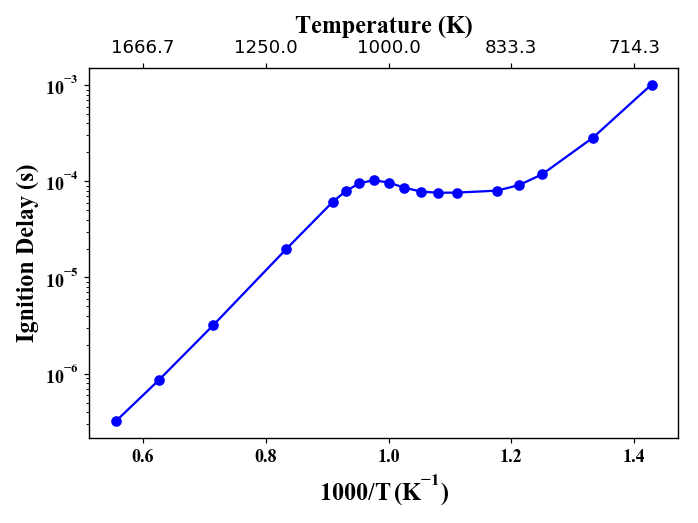

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000/ignitionDelays['T'], ignitionDelays['ignDelay'],'o-',color='b')
ax.set_ylabel('Ignition Delay (s)',fontname='Times New Roman',fontsize=16)
ax.set_xlabel(r'$\mathdefault{1000/T\, (K^{-1})}$', fontsize=16,fontname='Times New Roman')

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Temperature (K)',fontname='Times New Roman',fontsize=16);

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax2.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

## Repeat for an ideal gas:

In [22]:
gas = ct.Solution('input-files/WangMechanismRK.cti','WangmechanismIG')

In [23]:
# Make a list of all the temperatures we would like to run simulations at
T = [1800, 1600, 1400, 1200, 1100, 1075, 1050, 1025, 1000, 975, 950, 925, 900, 850, 825, 800,
     750, 700]

# Create an array of max simulation times:
estimatedIgnitionDelayTimes = 0.005*np.ones(len(T))

# Now create a dataFrame out of these
ignitionDelays_IG = pd.DataFrame(data={'T':T})
ignitionDelays_IG['ignDelay'] = np.nan

In [24]:
for i, temperature in enumerate(T):
    # Set up the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 100.0*101325.0
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel='c12h26', oxidizer={'o2':1.0, 'n2':3.76})
    r = ct.Reactor(contents=gas)
    reactorNetwork = ct.ReactorNet([r])

    
    # Now compile a list of all variables for which we will store data
    stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]
    # Create an empty data frame
    timeHistory = pd.DataFrame(columns=stateVariableNames)

    t0 = time.time()

    t = 0
    counter = 0
    while t < estimatedIgnitionDelayTimes[i]:
        t = reactorNetwork.step()
        if not counter % 20:
            timeHistory.loc[t] = r.get_state()
        counter += 1

    tau = ignitionDelay(timeHistory, 'oh')
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds for T={}K. Took {:3.2f}s to compute'.format(tau, temperature, t1-t0))

    ignitionDelays_IG.at[i, 'ignDelay'] = tau

Computed Ignition Delay: 3.469e-07 seconds for T=1800K. Took 0.95s to compute
Computed Ignition Delay: 9.380e-07 seconds for T=1600K. Took 1.13s to compute
Computed Ignition Delay: 3.563e-06 seconds for T=1400K. Took 1.05s to compute
Computed Ignition Delay: 2.222e-05 seconds for T=1200K. Took 1.17s to compute
Computed Ignition Delay: 6.911e-05 seconds for T=1100K. Took 1.21s to compute
Computed Ignition Delay: 8.975e-05 seconds for T=1075K. Took 1.31s to compute
Computed Ignition Delay: 1.096e-04 seconds for T=1050K. Took 1.44s to compute
Computed Ignition Delay: 1.198e-04 seconds for T=1025K. Took 1.51s to compute
Computed Ignition Delay: 1.150e-04 seconds for T=1000K. Took 1.53s to compute
Computed Ignition Delay: 1.026e-04 seconds for T=975K. Took 1.49s to compute
Computed Ignition Delay: 9.370e-05 seconds for T=950K. Took 1.39s to compute
Computed Ignition Delay: 9.118e-05 seconds for T=925K. Took 1.49s to compute
Computed Ignition Delay: 9.201e-05 seconds for T=900K. Took 1.82s t

<IPython.core.display.Javascript object>


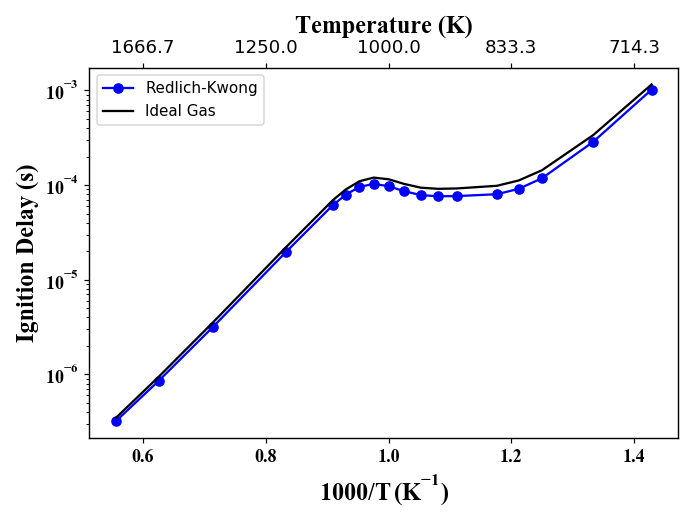

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000/ignitionDelays['T'], ignitionDelays['ignDelay'],'o-',color='b')
ax.semilogy(1000/ignitionDelays_IG['T'], ignitionDelays_IG['ignDelay'],'-',color='k')
ax.set_ylabel('Ignition Delay (s)',fontname='Times New Roman',fontsize=16)
ax.set_xlabel(r'$\mathdefault{1000/T\, (K^{-1})}$', fontsize=16,fontname='Times New Roman')
ax.legend(['Redlich-Kwong','Ideal Gas'])

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Temperature (K)',fontname='Times New Roman',fontsize=16);

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax2.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

## Extension - looking at non-ideal impacts on NTC.

Using Cantera's object-oriented nature, and branching functions in Git, it is possible to explore the impacts of non-ideal effects on NTC behavior.  

As published in _Combust. Flame_ in 2017 (see above for reference), we created three different thermodynamic models to explore NTC of n-dodecane:

- 'Ideal gas': An ideal gas model.
- 'R-K $\left(\left[X_k\right]\right)$': A model which (incorrectly) used used the Redlich-Kwong model for the equation of state (EoS - phase density and species concentrations) but uses the ideal gas model for chemical kinetics (i.e. activity coefficients 
$\gamma_k = 1$ and $\dot{q} = k_{\rm fwd}\prod\left[X_k\right]^{\nu^\prime_k} - k_{\rm rev}\prod\left[X_k\right]^{\nu^{\prime\prime}_k}$).
- 'R-K $\left(\gamma_k\right)$':A model which (correctly) used the Redlich-Kwong model for both EoS and activity coefficient calculations, such that $\dot{q} = k_{\rm fwd}\prod\left(\gamma_k\left[X_k\right]\right)^{\nu^\prime_k} - k_{\rm rev}\prod\left(\gamma_k\left[X_k\right]\right)^{\nu^{\prime\prime}_k}$

### "Low" pressure (40 atm)
<img src="images/IDT_40atm.png"  width="500">

